In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/florian/GitRepos/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os
import logging
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

from src.globals import *
from utils.visualization.show_image import show_image, plot_prediction
from utils.register_datasets import register_datasets, get_dataset_name
from utils.config_builder import get_config
from utils.notebook_utils import *
from utils.evaluation import SingleImageCOCOEvaluator
from utils.evaluation_accuracy import AccuracyEvaluator
from utils.evaluation_uncertainty import evaluate_uncertainties


from src.test import do_test
from src.active_learning.al_trainer import *
from src.active_learning.mc_dropout_sampler import *
from src.active_learning.tta_sampler import *


logger = setup_logger(output="./log/main.log",name="null_logger") 
logger.addHandler(logging.NullHandler())
logging.getLogger('detectron2').setLevel(logging.WARNING)
logging.getLogger('detectron2').addHandler(logging.NullHandler())

/home/florian/GitRepos/activeCell-ACDC
ac_acdc_env					output
acdc_large_cls_test_slim_coco_format.json	pipeline_configs
acdc_large_cls_test_slim_coco_format.json.lock	README.md
al_output					requirements.txt
data						shell_scripts
experiments					src
local						utils
log						wandb
notebooks


In [2]:
dataset = ACDC_LARGE_CLS
test_dataset_name = dataset + "_test_slim"
config_name = "final_random_al"

model_path = "/home/florian/GitRepos/activeCell-ACDC/output"

In [3]:
register_datasets()
train_data = DatasetCatalog.get(get_dataset_name(
    dataset, DATASETS_DSPLITS[dataset][0]
))

test_data = DatasetCatalog.get(test_dataset_name)

registering acdc_large_cls dataset
registering chlamy_dataset dataset


In [4]:
wandb.init(
    project="activeCell-ACDC",
    name="",
    sync_tensorboard=True,
    mode="disabled",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [5]:
default_cfg = get_config(config_name)
cfg = default_cfg
cfg.OUTPUT_DIR = "./al_output/classes_acdc_large_al"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05#.4
#cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2
#cfg.TEST.DETECTIONS_PER_IMAGE = 50

In [6]:
model = load_model(cfg, os.path.join(model_path, "best_model.pth"))
#model = load_model(cfg, os.path.join(model_path, "last_model1200.pth"))


In [8]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
model = load_model(cfg, os.path.join(model_path, "best_model.pth"))
evaluator = AccuracyEvaluator(test_dataset_name, cfg, False,output_dir="./" )
val_loader = build_detection_test_loader(cfg, test_dataset_name)

#Use the created predicted model in the previous step
res = inference_on_dataset(model, val_loader, evaluator)

TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_102
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_105
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_108
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_111
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_114
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_117
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_12
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_120
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_123
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_126
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_129
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_132
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_135
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_138
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_141
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_144
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_147
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_15
TimeLapse_2D_MIA

In [9]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
#stragtegy = MCDropoutSampler(cfg)
stragtegy = TTASampler(cfg)
model = patch_module(model)
res_unc = evaluate_uncertainties(cfg, test_dataset_name, model, stragtegy)

registering acdc_large_cls dataset
registering chlamy_dataset dataset


  2%|▏         | 12/509 [00:24<17:13,  2.08s/it]

In [17]:
res_df_unc = pd.DataFrame.from_records(res_unc)
res_df_unc[res_df_unc["detection_type"] == "tp"].head()
res_df_unc["class_right"] = res_df_unc["pred_class"] == res_df_unc["true_class"]
res_df_unc["cls_pred_vs_gt"] = res_df_unc["pred_class"]*10 + res_df_unc["true_class"]
res_df_unc["det_correct"] = res_df_unc["detection_type"] == "tp"
res_df_unc.head()

,image_id,object_id,pred_mask,iou,pred_class,true_class,detected,detection_type,u_sem,u_mask,u_det,class_right,cls_pred_vs_gt,det_correct
0,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,0,"[[False, False, False, False, False, False, Fa...",0.977778,1.0,1.0,True,tp,1.0,0.9825172,1.0,True,11.0,True
1,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,1,"[[False, False, False, False, False, False, Fa...",0.956743,2.0,2.0,True,tp,1.0,0.9908974,1.0,True,22.0,True
2,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,0,"[[False, False, False, False, False, False, Fa...",0.970996,1.0,1.0,True,tp,1.0,0.97355,1.0,True,11.0,True
3,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,1,"[[False, False, False, False, False, False, Fa...",0.970537,1.0,1.0,True,tp,1.0,0.98356766,1.0,True,11.0,True
4,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,2,"[[False, False, False, False, False, False, Fa...",0.983019,1.0,1.0,True,tp,1.0,0.98214287,1.0,True,11.0,True


In [10]:
# u_det
res_df_unc = pd.DataFrame.from_records(res_unc)
res_df_unc[res_df_unc["detection_type"] == "tp"].head()
res_df_unc["class_right"] = res_df_unc["pred_class"] == res_df_unc["true_class"]
res_df_unc["cls_pred_vs_gt"] = res_df_unc["pred_class"]*10 + res_df_unc["true_class"]
res_df_unc["det_correct"] = res_df_unc["detection_type"] == "tp"


num_bins = 10
res_df_unc["u_det"] = res_df_unc["u_det"].astype("float")
res_df_unc = res_df_unc[res_df_unc["detection_type"] != "fn"][["u_det","det_correct"]]


res_df_unc["u_det_bins"] = (num_bins * res_df_unc["u_det"]).apply(np.ceil) / num_bins
res_df_unc.groupby("u_det_bins").mean() 

ece_df = res_df_unc.groupby("u_det_bins").mean()[["det_correct","u_det"]].reset_index()



ece_df["calibration_error"] = (ece_df["det_correct"] - ece_df["u_det"]).apply(np.abs)

ece_df["bin_frac"] = res_df_unc.groupby("u_det_bins").count().reset_index()["u_det"]/len(res_df_unc)
ece_df["weighted_ce"] = ece_df["calibration_error"] * ece_df["bin_frac"]

ece_df["weighted_ce"].sum()


0.023260490646005404

In [11]:
# u_mask
res_df_unc = pd.DataFrame.from_records(res_unc)
res_df_unc[res_df_unc["detection_type"] == "tp"].head()
res_df_unc["class_right"] = res_df_unc["pred_class"] == res_df_unc["true_class"]
res_df_unc["cls_pred_vs_gt"] = res_df_unc["pred_class"]*10 + res_df_unc["true_class"]
res_df_unc["det_correct"] = res_df_unc["detection_type"] == "tp"


num_bins = 10
res_df_unc["u_mask"] = res_df_unc["u_mask"].astype("float")
res_df_unc = res_df_unc[res_df_unc["detection_type"] == "tp"][["u_mask","iou"]]


res_df_unc["u_det_bins"] = (num_bins * res_df_unc["u_mask"]).apply(np.ceil) / num_bins
res_df_unc.groupby("u_det_bins").mean() 

ece_df = res_df_unc.groupby("u_det_bins").mean()[["iou","u_mask"]].reset_index()



ece_df["calibration_error"] = (ece_df["iou"] - ece_df["u_mask"]).apply(np.abs)

ece_df["bin_frac"] = res_df_unc.groupby("u_det_bins").count().reset_index()["u_mask"]/len(res_df_unc)
ece_df["weighted_ce"] = ece_df["calibration_error"] * ece_df["bin_frac"]

ece_df["weighted_ce"].sum()



0.037678461406345704

In [12]:
# u_sem
res_df_unc = pd.DataFrame.from_records(res_unc)
res_df_unc[res_df_unc["detection_type"] == "tp"].head()
res_df_unc["class_right"] = res_df_unc["pred_class"] == res_df_unc["true_class"]
res_df_unc["cls_pred_vs_gt"] = res_df_unc["pred_class"]*10 + res_df_unc["true_class"]
res_df_unc["det_correct"] = res_df_unc["detection_type"] == "tp"


num_bins = 10
res_df_unc["u_sem"] = res_df_unc["u_sem"].astype("float")
res_df_unc = res_df_unc[res_df_unc["detection_type"] == "tp"][["u_sem","class_right"]]


res_df_unc["u_det_bins"] = (num_bins * res_df_unc["u_sem"]).apply(np.ceil) / num_bins
res_df_unc.groupby("u_det_bins").mean() 

ece_df = res_df_unc.groupby("u_det_bins").mean()[["class_right","u_sem"]].reset_index()



ece_df["calibration_error"] = (ece_df["class_right"] - ece_df["u_sem"]).apply(np.abs)

ece_df["bin_frac"] = res_df_unc.groupby("u_det_bins").count().reset_index()["u_sem"]/len(res_df_unc)
ece_df["weighted_ce"] = ece_df["calibration_error"] * ece_df["bin_frac"]

ece_df["weighted_ce"].sum()


0.058884331222736445

<Axes: xlabel='u_sem', ylabel='class_right'>

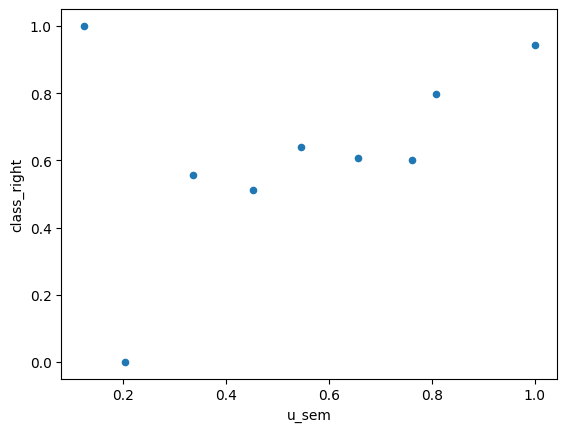

In [13]:
ece_df.plot.scatter(x="u_sem", y="class_right")



In [14]:
ece_df

,u_det_bins,class_right,u_sem,calibration_error,bin_frac,weighted_ce
0,0.2,1.000000,0.123741,0.876259,0.000118,0.000104
1,0.3,0.000000,0.202838,0.202838,0.000118,0.000024
2,0.4,0.555556,0.334848,0.220707,0.008523,0.001881
3,0.5,0.511111,0.452123,0.058988,0.005327,0.000314
4,0.6,0.640000,0.545670,0.094330,0.002959,0.000279
5,0.7,0.607843,0.656486,0.048643,0.006037,0.000294
6,0.8,0.600000,0.760495,0.160495,0.001776,0.000285
7,0.9,0.795918,0.807834,0.011916,0.005800,0.000069
8,1.0,0.942606,1.000000,0.057394,0.969342,0.055634


In [25]:
CATEGORIES = [
    {
        "id": 0,
        "name": "G1",
        "supercategory": "Cell",
    },
    {
        "id": 1,
        "name": "mother",
        "supercategory": "Cell",
    },
    {
        "id": 2,
        "name": "bud",
        "supercategory": "Cell",
    },

]

res_df_unc = pd.DataFrame.from_records(res_unc)
res_df_unc[res_df_unc["detection_type"] == "tp"].head()
res_df_unc["class_right"] = res_df_unc["pred_class"] == res_df_unc["true_class"]
res_df_unc["cls_pred_vs_gt"] = res_df_unc["pred_class"]*10 + res_df_unc["true_class"]
res_df_unc["det_correct"] = res_df_unc["detection_type"] == "tp"
res_df_unc.head()

res_df = res_df_unc[res_df_unc["detection_type"] == "tp"]
res_df = res_df.dropna()

res_df['true_class_name'] = res_df.apply(lambda row: CATEGORIES[int(row['true_class'])]["name"],axis=1)
res_df['pred_class_name'] = res_df.apply(lambda row: CATEGORIES[int(row['pred_class'])]["name"],axis=1)


print(pd.crosstab(res_df['true_class_name'], res_df['pred_class_name'], rownames=['GT class'], colnames=['Predicted Class'], values=res_df["u_sem"], aggfunc="mean").to_latex(index=True))


\begin{tabular}{lrrr}
\toprule
Predicted Class &        G1 &       bud &    mother \\
GT class &           &           &           \\
\midrule
G1       &  0.981685 &  0.921897 &  0.923038 \\
bud      &  0.872573 &  0.996493 &  0.855976 \\
mother   &  0.915687 &  0.809240 &  0.992844 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_10620/1161471954.py:34: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.crosstab(res_df['true_class_name'], res_df['pred_class_name'], rownames=['GT class'], colnames=['Predicted Class'], values=res_df["u_sem"], aggfunc="mean").to_latex(index=True))


In [16]:
res_df_unc[res_df_unc["detection_type"] != "fn"][["detection_type","u_sem","u_mask","u_det"]].groupby("detection_type").mean()

KeyError: 'detection_type'

<AxesSubplot: xlabel='iou', ylabel='u_mask'>

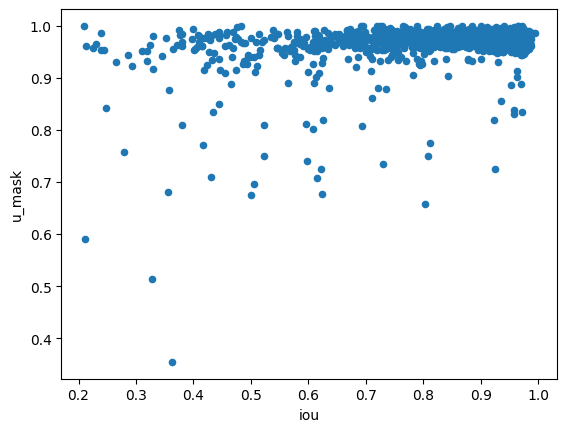

In [ ]:
res_df_unc[res_df_unc["detection_type"] == "tp"][["iou","u_mask"]].plot.scatter(x="iou", y="u_mask")

<AxesSubplot: xlabel='u_sem', ylabel='class_right'>

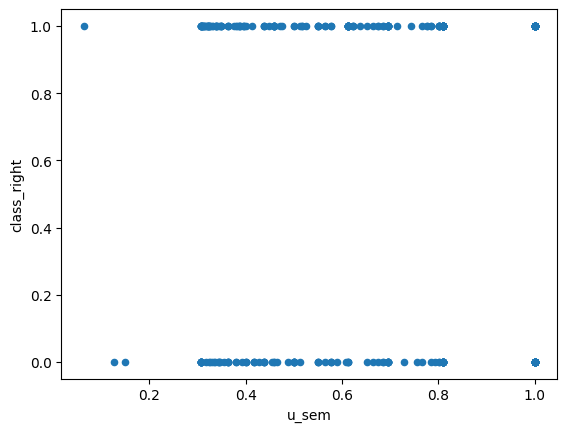

In [ ]:
res_df_unc["class_right"] = res_df_unc["class_right"].astype("float")
res_df_unc["u_sem"] = res_df_unc["u_sem"].astype("float")
res_df_unc[res_df_unc["detection_type"] == "tp"][["class_right","u_sem"]].plot.scatter(x="u_sem", y="class_right")

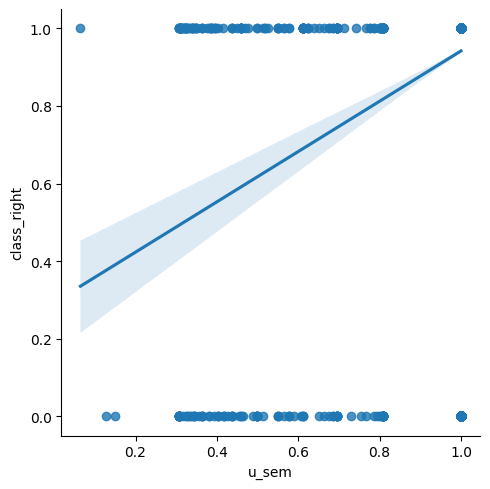

In [ ]:
import seaborn as sns
sns.lmplot(x='u_sem',y='class_right',data=res_df_unc[res_df_unc["detection_type"] == "tp"][["class_right","u_sem"]],fit_reg=True) 

In [57]:
res_df_unc[res_df_unc["detection_type"] == "tp"][["class_right","u_sem"]].corr()

,class_right,u_sem
class_right,1.000000,0.218282
u_sem,0.218282,1.000000


In [ ]:
res_df_unc[res_df_unc["detection_type"] == "tp"][["class_right","u_sem","u_mask","u_det"]].groupby("class_right").mean()

In [ ]:
res_df = pd.DataFrame.from_records(res)
print("precision:", len(res_df[res_df["detection_type"] == "tp"])/(len(res_df[res_df["detection_type"] == "fp"]) + len(res_df[res_df["detection_type"] == "tp"])))
print("recall:", len(res_df[res_df["detection_type"] == "tp"])/(len(res_df[res_df["detection_type"] == "fn"]) + len(res_df[res_df["detection_type"] == "tp"])))

precision: 0.7060270602706027
recall: 0.9912502878194797


In [ ]:
CATEGORIES = [
    {
        "id": 0,
        "name": "G1",
        "supercategory": "Cell",
    },
    {
        "id": 1,
        "name": "mother",
        "supercategory": "Cell",
    },
    {
        "id": 2,
        "name": "bud",
        "supercategory": "Cell",
    },

]

res_df = pd.DataFrame.from_records(res)
print("precision:", len(res_df[res_df["detection_type"] == "tp"])/(len(res_df[res_df["detection_type"] == "fp"]) + len(res_df[res_df["detection_type"] == "tp"])))
print("recall:", len(res_df[res_df["detection_type"] == "tp"])/(len(res_df[res_df["detection_type"] == "fn"]) + len(res_df[res_df["detection_type"] == "tp"])))
print("mean iou", res_df["iou"].mean())

res_df["class_right"] = res_df["pred_class"] == res_df["true_class"]

print("classification:", sum(res_df["class_right"] )/len(res_df["class_right"]))

res_list = []

for c in res_df["true_class"].unique():
    if c == c:
        res_list.append({
            "Class": CATEGORIES[int(c)]["name"],
            "Detection recall": sum(res_df[res_df["true_class"] == c]["detected"])/len(res_df[res_df["true_class"] == c]["detected"]),
            "Classification recall": sum(res_df[res_df["true_class"] == c]["class_right"])/len(res_df[res_df["true_class"] == c]["class_right"]),
            "Classification precision":sum(res_df[res_df["pred_class"] == c]["class_right"])/len(res_df[res_df["pred_class"] == c]["class_right"]),
            "Mean mask IoU": res_df[res_df["pred_class"] == c]["iou"].mean(),
        })        

print(pd.DataFrame.from_records(res_list).to_latex(index=False))

precision: 0.9799346710219319
recall: 0.9670734515311996
mean iou 0.9318156278512114
classification: 0.8899300067735381
\begin{tabular}{lrrrr}
\toprule
 Class &  Detection recall &  Classification recall &  Classification precision &  Mean mask IoU \\
\midrule
mother &          0.983689 &               0.937265 &                  0.921085 &       0.960756 \\
   bud &          0.946675 &               0.930678 &                  0.938034 &       0.882571 \\
    G1 &          0.972294 &               0.834632 &                  0.890531 &       0.959529 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_15624/4010765554.py:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame.from_records(res_list).to_latex(index=False))


In [ ]:
print(res_df[res_df["detection_type"] == "fp"].groupby("pred_class").count().reset_index()[["pred_class","image_id"]])
print(res_df[res_df["detection_type"] == "fn"].groupby("true_class").count().reset_index()[["pred_class","image_id"]])

   pred_class  image_id
0         0.0        45
1         1.0        40
2         2.0        87
   pred_class  image_id
0           0        64
1           0        52
2           0       170


In [ ]:
res_df[res_df["detection_type"] == "tp"]

,image_id,object_id,pred_mask,iou,pred_class,true_class,detected,detection_type,class_right
0,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,0,"[[[False, False, False, False, False, False, F...",0.981844,1.0,1.0,True,tp,True
1,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,1,"[[[False, False, False, False, False, False, F...",0.959184,2.0,2.0,True,tp,True
2,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,0,"[[[False, False, False, False, False, False, F...",0.970849,1.0,1.0,True,tp,True
3,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,1,"[[[False, False, False, False, False, False, F...",0.970537,1.0,1.0,True,tp,True
4,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,2,"[[[False, False, False, False, False, False, F...",0.982987,1.0,1.0,True,tp,True
...,...,...,...,...,...,...,...,...,...
8853,acdc_data3_Yagya_SCD_WT_pos_6_9,13,"[[[False, False, False, False, False, False, F...",0.958885,1.0,1.0,True,tp,True
8854,acdc_data3_Yagya_SCD_WT_pos_6_9,14,"[[[False, False, False, False, False, False, F...",0.922144,2.0,2.0,True,tp,True
8855,acdc_data3_Yagya_SCD_WT_pos_6_9,15,"[[[False, False, False, False, False, False, F...",0.957087,2.0,2.0,True,tp,True
8856,acdc_data3_Yagya_SCD_WT_pos_6_9,16,"[[[False, False, False, False, False, False, F...",0.966292,2.0,2.0,True,tp,True


In [ ]:
res_df.groupby(by=["true_class","pred_class"]).count()

image_id  object_id  pred_mask   iou  detected  \
true_class pred_class                                                   
0          0.0             1955       1955       1955  1955      1955   
           1.0              226        226        226   226       226   
           2.0              113        113        113   113       113   
1          0.0              168        168        168   168       168   
           1.0             3009       3009       3009  3009      3009   
           2.0                2          2          2     2         2   
2          0.0               51         51         51    51        51   
           1.0                6          6          6     6         6   
           2.0             3080       3080       3080  3080      3080   

                       class_right  
true_class pred_class               
0          0.0                1955  
           1.0                 226  
           2.0                 113  
1          0.0                 168  
           1.0                3009  
           2.0                   2  
2          0.0                  51  
           1.0                   6  
           2.0                3080

In [ ]:
res_df = res_df.dropna()

res_df['true_class_name'] = res_df.apply(lambda row: CATEGORIES[int(row['true_class'])]["name"],axis=1)
res_df['pred_class_name'] = res_df.apply(lambda row: CATEGORIES[int(row['pred_class'])]["name"],axis=1)


print(pd.crosstab(res_df['true_class_name'], res_df['pred_class_name'], rownames=['GT class'], colnames=['Predicted Class']).to_latex(index=True))

\begin{tabular}{lrrr}
\toprule
Predicted Class &    G1 &   bud &  mother \\
GT class &       &       &         \\
\midrule
G1       &  2201 &   294 &     891 \\
bud      &   247 &  3494 &      18 \\
mother   &   726 &    17 &    3168 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_7541/1335671770.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.crosstab(res_df['true_class_name'], res_df['pred_class_name'], rownames=['GT class'], colnames=['Predicted Class']).to_latex(index=True))
